In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [2]:
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import (PiecewisePolynomial, 
                         InverseKinematics, 
                         Sphere, 
                         Rgba, 
                         RigidTransform, 
                         RotationMatrix, 
                         Solve,
                         MathematicalProgram,
                         RollPitchYaw,
                         Cylinder)
import time
import pydrake

In [3]:
from environments import get_environment_builder

plant_builder = get_environment_builder('7DOFBINS')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
def show_pose(qvis, plant, plant_context, diagram, diagram_context, endeff_frame, show_body_frame = None):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    transl = tf.translation()+tf.rotation()@np.array([0,0.1,0])
    if show_body_frame is not None:
        show_body_frame(RigidTransform(tf.rotation(), transl))

def show_ik_target(pose, meshcat, name):
    h = 0.2
    if 'targ' in name:
        colors = [Rgba(1,0.5,0, 0.5), Rgba(0.5,1,0, 0.5), Rgba(0.0,0.5,1, 0.5)]
    else:
        colors = [Rgba(1,0,0, 1), Rgba(0.,1,0, 1), Rgba(0.0,0.0,1, 1)]

    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([h/2, 0,0])
    meshcat.SetObject(f"/drake/ik_target{name}/triad1",
                                   Cylinder(0.01,0.2),
                                   colors[0])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad1",RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,h/2,0])

    meshcat.SetObject(f"/drake/ik_target{name}/triad2",
                                   Cylinder(0.01,0.2),
                                   colors[1])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad2",RigidTransform(rot, pos))
    pos= pose.translation().copy()
    rot = pose.rotation()
    pos = pos + rot@np.array([0,0,h/2])
    meshcat.SetObject(f"/drake/ik_target{name}/triad3",
                                   Cylinder(0.01,0.2),
                                   colors[2])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad3",RigidTransform(rot, pos))
from visualization_utils import get_shunk_plotter

plot_endeff_poses = get_shunk_plotter(plant, scene_graph, plant_context, diagram_context)

{'body': <GeometryId value=69>, 'left_finger': <GeometryId value=75>, 'right_finger': <GeometryId value=81>}


/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
show_body_frame = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_acutal', 
                          )
showres = partial(show_pose, 
                  plant = plant, 
                  plant_context = plant_context, 
                  diagram = diagram, 
                  diagram_context = diagram_context,
                  endeff_frame = 'body',
                  show_body_frame=show_body_frame)

In [6]:
from visualization_utils import plot_points, plot_regions
from pydrake.all import VPolytope, Role
from task_space_seeding_utils import (get_cvx_hulls_of_bodies,
                                      get_AABB_cvxhull,
                                      task_space_sampler_mp,
                                      task_space_sampler)

In [7]:
def densify_waypoints(waypoints_q, densify = 200):
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName('body'))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName('body'))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [8]:
#Samplers for testing coverage
from visibility_utils import generate_distinct_colors
offset_size = -0.05
geom_names = ['bin_base', 
              'bin_base', 
              'shelves_body']
model_names = ['binL', 
               'binR', 
               'shelves']
default_pos = [np.array([ 1.53294,  0.4056 ,  0.23294, -0.5944 ,0.,0.9056 ,0.]),
               np.array([-1.53294,  0.4056 ,  0.23294, -0.5944 ,0.,  0.9056 ,0. ]),
               np.array([ 0., -0.08940423,  0., -1.7087849,  0., 1.32867852,  0.])]
approach_dir = [2, 
                2, 
                0] 
approach_sign = [1,1,-1]
ts_samplers = []
cols = generate_distinct_colors(2*len(model_names), rgb = True)[1:]
#cols = [list(c)+[1] for c in cols]
AABB_sampling_regions = []
for i, (g, m) in enumerate(zip(geom_names, model_names)):
    cvx_hulls_of_ROI_unsc, bodies = get_cvx_hulls_of_bodies([g], [m], plant, scene_graph, scene_graph_context, scaling = 1.0)
    verts = [VPolytope(c).vertices().T for c in cvx_hulls_of_ROI_unsc]
    cvx_hulls_of_ROI = cvx_hulls_of_ROI_unsc
    cvx_hulls_of_ROI = []
    for v in verts:
        offset = approach_sign[i]*(np.sign(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]]))==approach_sign[i])*offset_size
        v[:,approach_dir[i]] += offset #scale*(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]])) +  np.mean(v[:,approach_dir[i]])
        cvx_hulls_of_ROI.append(HPolyhedron(VPolytope(v.T)))
    ts_min, ts_max, cvxh_hpoly = get_AABB_cvxhull(cvx_hulls_of_ROI)
    AABB_sampling_regions.append([ts_min, ts_max])
    plot_regions(meshcat, cvx_hulls_of_ROI, region_suffix=m,opacity=0.2, colors=[cols[i]])
    q0  = default_pos[i] #np.zeros(7)
    plant.SetPositions(plant_context, q0)
    plant.ForcedPublish(plant_context)
    showres(q0)
    t0 = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("body")).translation()       
    sample_handle_ts = partial(task_space_sampler_mp,
                            q0 = q0,
                            t0 = t0,
                            plant_builder = plant_builder,
                            frame_names = ['body'],
                            offsets = [np.array([0,0.1,0])],
                            cvx_hulls_of_ROI =cvx_hulls_of_ROI,
                            ts_min = ts_min,
                            ts_max = ts_max,
                            collision_free = True,
                            track_orientation = True,
                            axis_alignment = approach_dir[i]
                            )
    ts_samplers.append(sample_handle_ts)

In [9]:
from pydrake.all import SceneGraphCollisionChecker
from visibility_utils import vgraph
from clique_covers import compute_greedy_clique_partition

robot_instances = [plant.GetModelInstanceByName("iiwa"), plant.GetModelInstanceByName("wsg")]
checker = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
                    robot_model_instances = robot_instances,
                    distance_function_weights =  [1] * plant.num_positions(),
                    #configuration_distance_function = _configuration_distance,
                    edge_step_size = 0.02)
vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 

INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


In [10]:
import os
import pickle
Npts= 500
if f"7dof_bin_test_samps{Npts}_{offset_size}.pkl" in os.listdir('tmp'):
    with open(f"tmp/7dof_bin_test_samps{Npts}_{offset_size}.pkl", 'rb') as f:
        d = pickle.load(f)
        q_obj = d['q_obj']
        t_obj = d['t_obj']
        ad_mat = d['ad_obj']
else:
    q_obj = []
    t_obj = []
    ad_obj = []
    for sh in ts_samplers:
        q, t, _, res = sh(Npts,[])
        ad_mat = vgraph_handle(q)
        q_obj +=[q]
        t_obj +=[t]
        ad_obj +=[ad_obj]
    with open(f"tmp/7dof_bin_test_samps{Npts}_{offset_size}.pkl", 'wb') as f:
        pickle.dump({'q_obj':q_obj, 't_obj':t_obj, 'ad_obj': ad_obj}, f)

In [11]:
# meshcat.Delete('/iris/shunk')
# meshcat.SetProperty('/iris/regionsshelves', 'visible', False)
# plot_endeff_poses(meshcat, q_obj[0])

In [12]:
from visibility_utils import check_visibility_to_regions
from utils import load_regions_from_experiment_dir

regions_c = load_regions_from_experiment_dir(
                    'logs/experiment_7dof_iiwa_bins_taskspace_1_1500_0.400greedy20231024205238')

#7dof_bin_regions_noapproachdir_2000_0.05_1337
#7dof_bin_regions_2000_0.05_1337.pkl
with open(f"tmp/7dof_bin_regions_noapproachdir_2000_0.05_1337.pkl", 'rb') as f:
    d = pickle.load(f)
    regions_shelves = d['r']

Text(0.5, 1.0, 'connectivity')

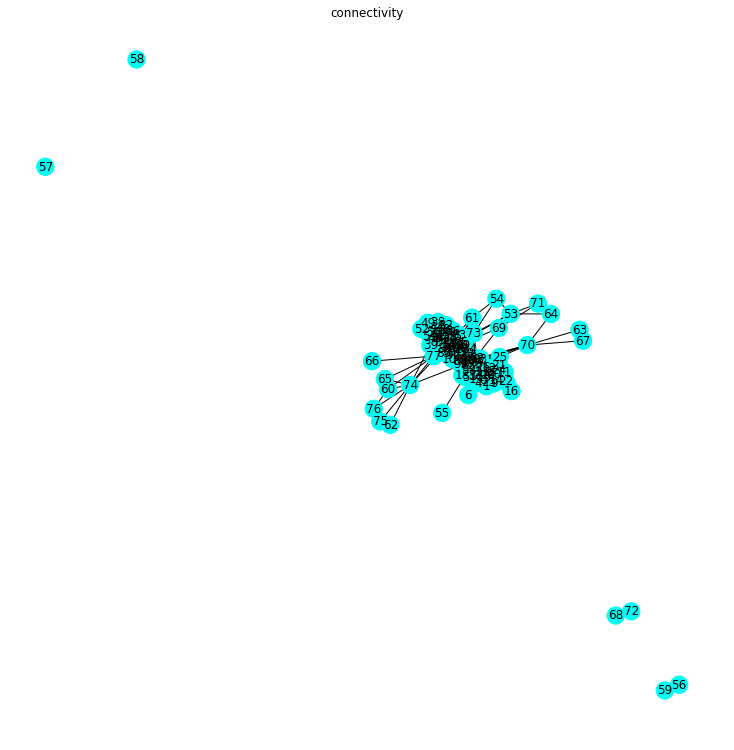

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors
regs = regions_shelves+regions_c
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regs], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [14]:
from dijkstraspp import DijkstraSPP
# checker_dspp = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
#                     robot_model_instances = robot_instances,
#                     distance_function_weights =  [1] * plant.num_positions(),
#                     #configuration_distance_function = _configuration_distance,
#                     edge_step_size = 0.01)
dspp = DijkstraSPP(regions_connected_component, checker, verbose=True)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 101
[DijkstraSPP] Pre-Building adjacency matrix  10 / 101
[DijkstraSPP] Pre-Building adjacency matrix  20 / 101
[DijkstraSPP] Pre-Building adjacency matrix  30 / 101
[DijkstraSPP] Pre-Building adjacency matrix  40 / 101
[DijkstraSPP] Pre-Building adjacency matrix  50 / 101
[DijkstraSPP] Pre-Building adjacency matrix  60 / 101
[DijkstraSPP] Pre-Building adjacency matrix  70 / 101
[DijkstraSPP] Pre-Building adjacency matrix  80 / 101
[DijkstraSPP] Pre-Building adjacency matrix  90 / 101
[DijkstraSPP] Pre-Building adjacency matrix  100 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  0 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  10 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  20 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  30 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  40 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  50 / 101
[DijkstraSPP] Pre-Building safe-adjacency matrix  60 

In [15]:
q_tot = np.concatenate(tuple(q_obj))

In [26]:
q_obj_vis_idx = []
for i in range(3):
    visible_centers = check_visibility_to_regions(q_obj[i], regions_connected_component, checker)
    visibility_coverage = np.mean([1 if len(v) else 0 for v in visible_centers])
    print(visibility_coverage)
    q_obj_vis_idx.append(np.where([len(v) for v in visible_centers])[0])

0.994
0.996
0.532


In [27]:
q_obj_vis = [q_obj[i][qidx] for i, qidx in enumerate(q_obj_vis_idx)]

In [28]:
meshcat.Delete('/iris/shunk')
plot_endeff_poses(meshcat, np.concatenate(tuple(q_obj_vis),axis = 0)[::2])

In [31]:
import time
from visibility_utils import point_in_regions
centers = [r.ChebyshevCenter() for r in regions_connected_component]
# meshcat.SetProperty(f"/Grid", "visible", False)
# meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)
objs = [0,1,2,2,2]

np.random.seed(112)
start = centers[1]
cur_time = 0
obj = 0
dist_ratio = []
cols = []
for _ in range(100):
    #nxt = vs.sample_in_regions() #
    nxt = q_obj_vis[obj][np.random.choice(len(q_obj_vis[obj]))]
    objidx = np.random.choice(len(objs))
    obj = objs[objidx]
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    #wp2, dist2 = dspp2.solve(start, nxt, refine_path=True)
    #dist_ratio.append([dist, dist2])
    #print(dist)
    meshcat.Delete("/iris/points/traj/")
    dense_waypoints = densify_waypoints(wp, densify=100)
    dense_waypoints_plt = densify_waypoints(wp, densify=90)
    plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints:
        #anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        #diagram_context.SetTime(cur_time)
        if not checker.CheckConfigCollisionFree(qa):
            print('col')
            cols.append(wp)
            
            break
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        #frame+=1
        time.sleep(0.01)
    start = nxt.copy()
    time.sleep(0.01)
        
        # meshcat.Delete("/iris/points/traj/")

53
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 6.30 / 7.80 = 0.81
356
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 14.21 / 14.63 = 0.97
456
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 8.80 / 9.48 = 0.93
207
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] optimized distance/ start-distance = 5.71 / 7.40 = 0.77
127
[DijkstraSPP] optimized distance/ start-distance = 4.93 / 5.86 = 0.84
280
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 5.91 / 7.05 = 0.84
304
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
143
[DijkstraSPP] Attempting visibility extension for sta

KeyboardInterrupt: 

In [21]:
cols[0]

[array([ 1.48154867,  0.57168651,  0.27176364, -1.58355748, -0.41569331,
         0.94480828, -1.32896028]),
 array([ 1.17418488,  0.5570616 ,  0.22913215, -1.66059692, -0.02802541,
         0.86231895, -0.44658728]),
 array([-1.38473695,  0.60535617, -0.16707129, -1.88802861,  0.17961375,
         0.49833209,  0.74410805])]

In [20]:
wps_problem = wp 
[start_p, target_p]=dist 

In [25]:
dspp.refine_path_SOCP(wps_problem, start_p, target_p, [1, -2])

[DijkstraSPP] Refine path SCOP failed


(array([1463,  803,  935, 1409, 1456,  403,  390,   15, 1464]),
 [array([-1.38473695,  0.60535617, -0.16707129, -1.88802861,  0.17961375,
          0.49833209,  0.74410805]),
  array([ 1.52588808,  0.26182172,  0.02066826, -1.86727358, -0.17205274,
          0.94465888, -0.88172573])])

In [24]:
[len(wps_problem)+i if i<0 else i for i in [1, -2]]

[1, 7]

In [29]:
#intermediate_nodes = [self.node_intersections[idx] for idx in wps[1:-1]]
from pydrake.all import eq
dim = len(start_p)
fixed_idx = [1,-2]
prog = MathematicalProgram()
wps = np.array(wps_problem)
int_waypoints = prog.NewContinuousVariables(len(wps[1:-1]), dim)
for i, wp in enumerate(wps[1:-1]):
    dspp.safe_sets[wp].AddPointInSetConstraints(prog, int_waypoints[i,:])
#convert fixed_idx 
fixed_idx_conv = [len(wps)+i if i<0 else i for i in fixed_idx]
for i in fixed_idx_conv:
    prog.AddLinearConstraint(eq(int_waypoints[i-1,:], dspp.reppts[wps[1:-1][i-1],:]))

prev = start_p
cost = 0 
for idx in range(len(wps[1:-1])):
    t = prog.NewContinuousVariables(dim+1, 't'+str(idx))
    prog.AddConstraint(eq(t[1:], prev-int_waypoints[idx]))
    prev = int_waypoints[idx]
    prog.AddLorentzConeConstraint(t)
    cost += t[0]
t = prog.NewContinuousVariables(dim+1, 'tend')
prog.AddConstraint(eq(t[1:], prev-target_p))
prog.AddLorentzConeConstraint(t)
prog.SetInitialGuess(int_waypoints, dspp.reppts[wps[1:-1]])
cost += t[0]
prog.AddCost(cost)

res = Solve(prog)
if res.is_success():
    path = [start]
    for i in res.GetSolution(int_waypoints):
        path.append(i)
    path.append(target_p)
    wps_start = [dspp.reppts[idx] for idx in wps[1:-1]]
    dist_start = 0
    prev = start
    for wp in wps_start + [target_p]:
        #dist_start += np.linalg.norm()#* np.array([4.0,3.5,3,2.5,2,2.5,1])
        a = prev-wp
        dist_start += np.sqrt(a.T@a)
        prev = wp
    if dspp.verbose: print("[DijkstraSPP] optimized distance/ start-distance = {opt:.2f} / {start:.2f} = {res:.2f}".format(opt = res.get_optimal_cost(), start = dist_start, res = res.get_optimal_cost()/dist_start))
    print(path, res.get_optimal_cost())
else:
    print("[DijkstraSPP] Refine path SCOP failed")
    print( wps, [start_p,target_p])

[DijkstraSPP] Refine path SCOP failed
[1463  803  935 1409 1456  403  390   15 1464] [array([-1.38473695,  0.60535617, -0.16707129, -1.88802861,  0.17961375,
        0.49833209,  0.74410805]), array([ 1.52588808,  0.26182172,  0.02066826, -1.86727358, -0.17205274,
        0.94465888, -0.88172573])]


In [30]:
for i in wps[1:-1]:
    pt = dspp.reppts[i]
    print(dspp.safe_sets[i].PointInSet(pt))


True
True
True
True
True
True
False


In [35]:
wps[-2]

15

In [38]:
p = dspp.reppts[15,:]
r =dspp.safe_sets[15] 
np.max(r.A()@p - r.b())

1.0047917387012717e-08

In [28]:
from pydrake.all import ChooseBestSolver
ChooseBestSolver(prog).name()

'Mosek'

In [22]:
for i in range(len(cols[0])-1):
    print(checker.CheckEdgeCollisionFreeParallel(cols[0][i], cols[0][i+1]))

True
False


In [50]:
for r in regions_shelves:
    print(point_in_regions(q_tot[2], [r]))

True
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [49]:
center = regions_shelves[1].MaximumVolumeInscribedEllipsoid().center()
pt = q_tot[2]
print(point_in_regions(pt, [regions_shelves[5]]))
print(checker.CheckEdgeCollisionFreeParallel(pt,center))

False
True


In [41]:
point_in_regions(q_tot[2], [regions_shelves[0]])

True

In [ ]:
q_tot[2]

In [22]:
from visibility_utils import point_in_regions
inreg = 0
for q in q_tot:
    if point_in_regions(q, regions_shelves):
        inreg+=1
print(inreg/len(q_tot))

0.33666666666666667


In [17]:
visible_centers

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
